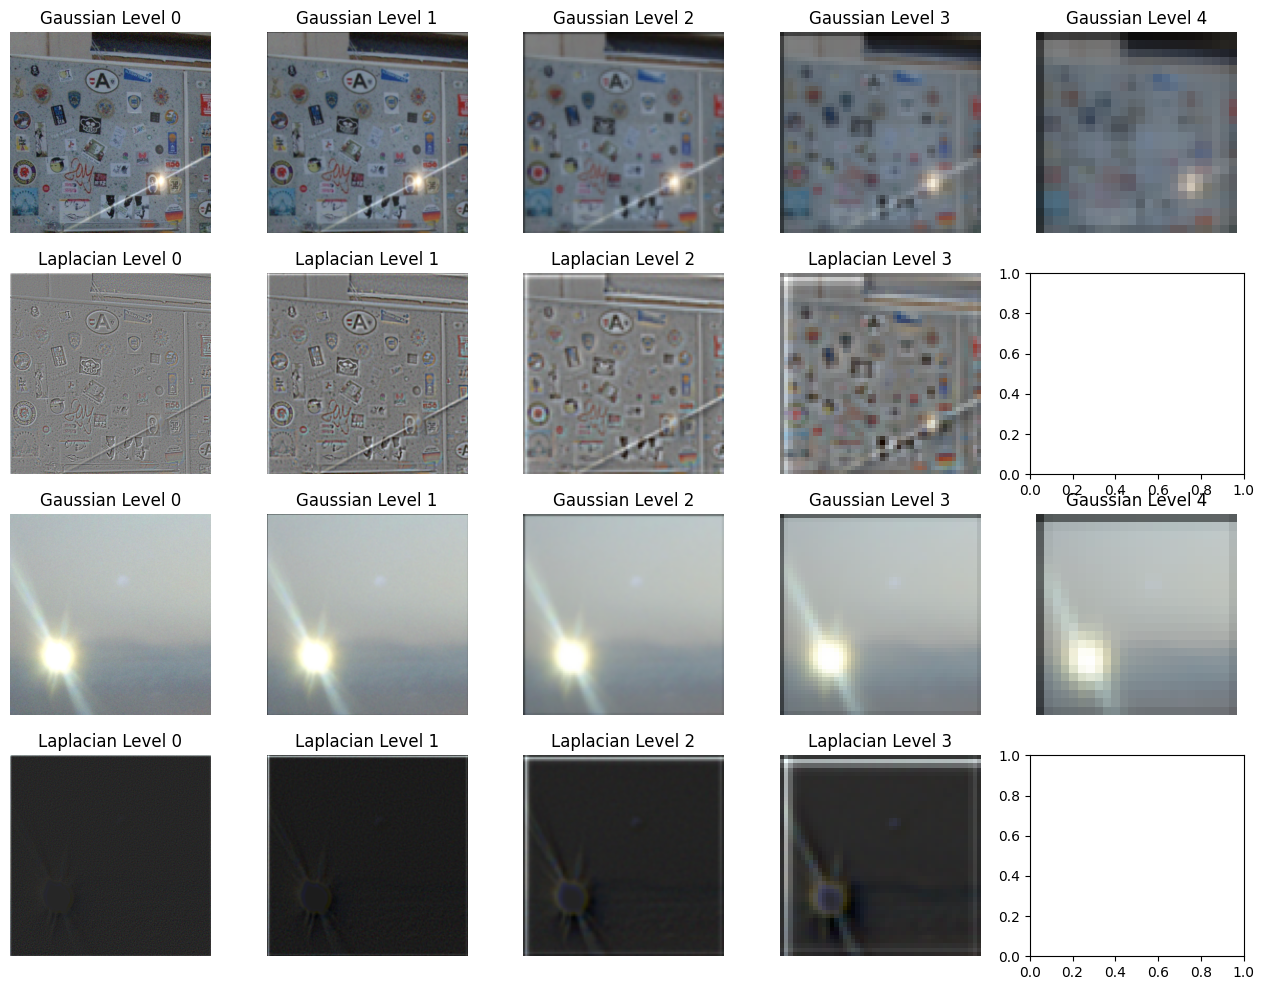

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


class EBlock(nn.Module):
    def __init__(self, channels):
        super(EBlock, self).__init__()

    def forward(self, x):
        return x


class DBlockPred(nn.Module):
    def __init__(self, channel, num_res, data):
        super(DBlockPred, self).__init__()

    def forward(self, x):
        return x


class DBlockFlare(nn.Module):
    def __init__(self, channel, num_res, data):
        super(DBlockFlare, self).__init__()

    def forward(self, x):
        return x


# gaussian transform block
def GTB(x,layer=4):
    res_gaussian = []
    res_laplacian = []
    kernel = torch.tensor([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]], dtype=torch.float32, device=x.device) / 256.0
    b, c, h, w = x.shape
    kernel = kernel.view(1, 1, 5, 5).repeat(c, 1, 1, 1)
    current = x
    res_gaussian.append(current)
    for i in range(layer):
        blurred = F.conv2d(current, kernel, padding=2, groups=c)
        blurred = blurred[:, :, ::2, ::2]
        res_gaussian.append(blurred)
        upsampled = F.interpolate(blurred, size=current.shape[2:], mode='bilinear', align_corners=False)
        laplacian = current - upsampled
        res_laplacian.append(laplacian)
        current = blurred
    return res_gaussian, res_laplacian

def tensor_to_pil(tensor):
    tensor = tensor.cpu().detach()
    if tensor.dim() == 3:
        tensor = tensor.permute(1, 2, 0)
    tensor = torch.clamp(tensor, 0, 1)
    array = (tensor.numpy() * 255).astype(np.uint8)
    return Image.fromarray(array)

if __name__ == '__main__':
    from PIL import Image
    import torch
    import torch.nn.functional as F
    import matplotlib.pyplot as plt
    import numpy as np
    from torchvision import transforms
    
    # 设置图像路径
    image_path1 = "E:/dataset/flare7kpp_r_local/input/c0/48.png"
    image_path2 = "E:/dataset/flare7kpp_r_local/input/c0/49.png" 
    
    # 1. 读取图像
    original_image = Image.open(image_path1).convert('RGB')
    original_image2 = Image.open(image_path2).convert('RGB')
    
    # 2. 将图像转换为PyTorch张量
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(), 
    ])
    img_tensor = torch.stack((transform(original_image),transform(original_image2)))
    g,l = GTB(img_tensor,layer=4)
    
    fig, axes = plt.subplots(4, len(g), figsize=(16, 12))
    
    # 显示高斯金字塔
    for i, img_tensor in enumerate(g):
        img = tensor_to_pil(img_tensor[0])
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Gaussian Level {i}')
        axes[0, i].axis('off')
        img = tensor_to_pil(img_tensor[1])
        axes[2, i].imshow(img)
        axes[2, i].set_title(f'Gaussian Level {i}')
        axes[2, i].axis('off')
    
    # 显示拉普拉斯金字塔（需要归一化以便可视化）
    for i, img_tensor in enumerate(l):
        img = img_tensor[0]
        # 对拉普拉斯图像进行归一化以便可视化
        laplacian_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = tensor_to_pil(laplacian_norm)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Laplacian Level {i}')
        axes[1, i].axis('off')
    
        img = img_tensor[1]
        # 对拉普拉斯图像进行归一化以便可视化
        laplacian_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = tensor_to_pil(laplacian_norm)
        axes[3, i].imshow(img)
        axes[3, i].set_title(f'Laplacian Level {i}')
        axes[3, i].axis('off')
    